In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [38]:
df = pd.read_csv("../../results/aggregated.csv")
df["hostname"] = [hostname.strip() for hostname in df["hostname"]]
hostnames = set(df["hostname"].values)
benchmarks = set(df["benchmark"].values)
colors = list(mcolors.TABLEAU_COLORS.keys())

In [40]:
supercomputers = ["wheeler", "xena", "hopper"]
clock_speeds = {
    "xena": 2.60,
    "yucca": 2.4,
    "leda": 3.6,
    "Aureolin": 2.688,
    "wheeler": 2.67,
    "Celeste": 3.2,
    "ocotillo": 2.4,
    "mack": 3.5,
    "sahu": 2.0,
    "hopper": 2.9
}
num_cores = {
    "xena": 16,
    "yucca": 16,
    "leda": 16,
    "Aureolin": 10,
    "wheeler": 8,
    "Celeste": 6,
    "ocotillo": 4,
    "mack": 4,
    "sahu": 128,
    "hopper": 64
}
df["clock_speed"] = [clock_speeds[hostname] for hostname in df["hostname"]]
df["num_cores"] = [num_cores[hostname] for hostname in df["hostname"]]
df["norm"] = df["avg_time"] * df["clock_speed"]
df["norm_std"] = df["std_dev"] * np.sqrt(df["clock_speed"])
df["scaled"] = df["avg_time"] * df["num_cores"] / df["num_procs"]
df["scaled_std"] = df["avg_time"] * np.sqrt(df["num_cores"] / df["num_procs"])
df["super"] = [1 if hostname in supercomputers else 0 for hostname in df["hostname"]]

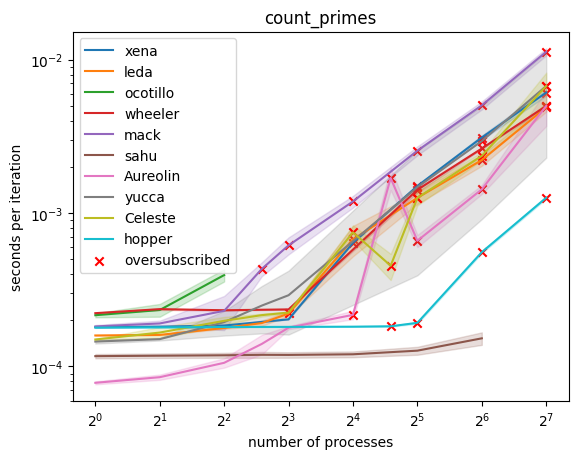

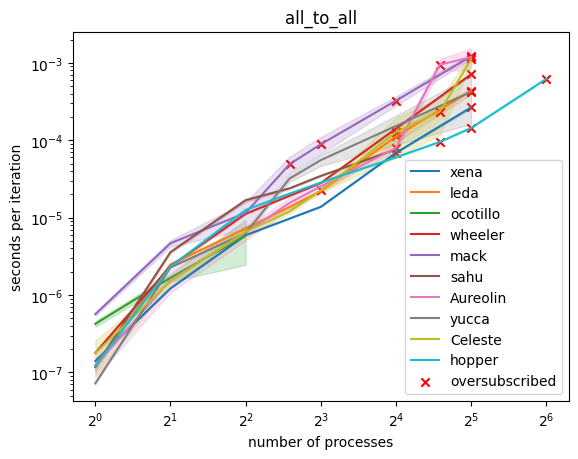

In [41]:
for benchmark in benchmarks:
    fig, ax = plt.subplots()
    ax.set_title(benchmark)
    bench_df = df[df["benchmark"] == benchmark]
    for i, hostname in enumerate(hostnames):
        series = bench_df[bench_df["hostname"] == hostname]
        avg = series.groupby("num_procs", as_index=False)["avg_time"].mean()
        std = series.groupby("num_procs", as_index=False)["std_dev"].mean()
        nprocs = avg["num_procs"]
        avg = avg["avg_time"]
        std = std["std_dev"]
        
        ax.fill_between(nprocs, avg + std, avg - std, alpha=0.2, color=colors[i])
        ax.plot(nprocs, avg, label=hostname, color=colors[i])

        oversubscribed = series[series["oversubscribed"] == 1]
        avg = oversubscribed.groupby("num_procs", as_index=False)["avg_time"].mean()
        nprocs = avg["num_procs"]
        avg = avg["avg_time"]

        if i == len(hostnames) - 1:
            ax.scatter(nprocs, avg, label="oversubscribed", marker="x", color="red")
        else:
            ax.scatter(nprocs, avg, marker="x", color="red")

    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.legend()
    ax.set_xlabel("number of processes")
    ax.set_ylabel("seconds per iteration")
    plt.savefig(benchmark + ".pdf", bbox_inches="tight")
    plt.show()

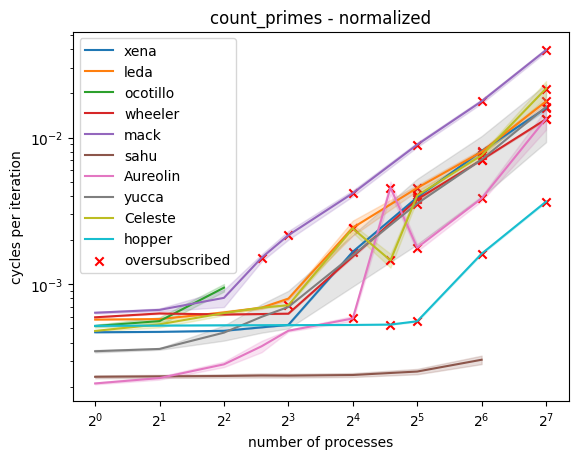

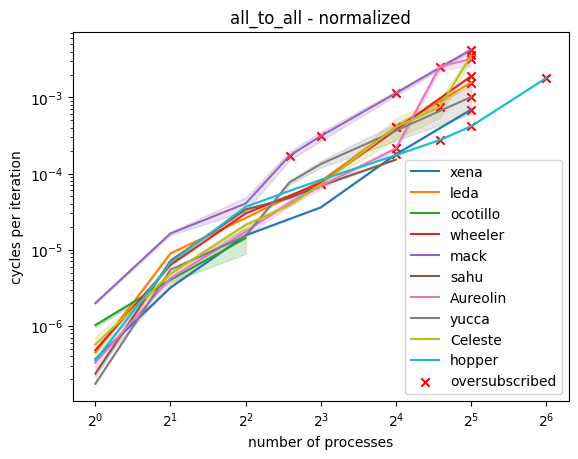

In [42]:
for benchmark in benchmarks:
    fig, ax = plt.subplots()
    ax.set_title(benchmark + " - normalized")
    bench_df = df[df["benchmark"] == benchmark]
    for i, hostname in enumerate(hostnames):
        series = bench_df[bench_df["hostname"] == hostname]
        avg = series.groupby("num_procs", as_index=False)["norm"].mean()
        std = series.groupby("num_procs", as_index=False)["norm_std"].mean()
        nprocs = avg["num_procs"]
        avg = avg["norm"]
        std = std["norm_std"]
        
        ax.fill_between(nprocs, avg + std, avg - std, alpha=0.2, color=colors[i])
        ax.plot(nprocs, avg, label=hostname, color=colors[i])
        
        oversubscribed = series[series["oversubscribed"] == 1]
        avg = oversubscribed.groupby("num_procs", as_index=False)["norm"].mean()
        nprocs = avg["num_procs"]
        avg = avg["norm"]

        if i == len(hostnames) - 1:
            ax.scatter(nprocs, avg, label="oversubscribed", marker="x", color="red")
        else:
            ax.scatter(nprocs, avg, marker="x", color="red")
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.legend()
    ax.set_xlabel("number of processes")
    ax.set_ylabel("cycles per iteration")
    plt.savefig(benchmark + "_normalized.pdf", bbox_inches="tight")
    plt.show()

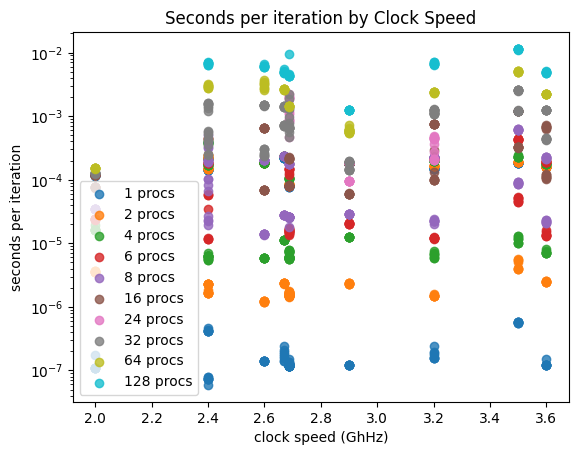

In [43]:
fig, ax = plt.subplots()

nprocs = np.sort(list(set(df["num_procs"].values)))
np.sort(nprocs)

for num_procs in nprocs:
    subdf = df[df["num_procs"] == num_procs]
    ax.scatter(subdf["clock_speed"], subdf["avg_time"], label=f"{num_procs} procs", alpha=0.8)
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("clock speed (GhHz)")
ax.set_ylabel("seconds per iteration")
ax.set_title("Seconds per iteration by Clock Speed")
plt.savefig("correlation.pdf", bbox_inches="tight")
plt.show()

In [50]:
subdf = df[df["num_procs"] == 4]
subdf = df[df["benchmark"] == "all_to_all"]
corr = subdf[["avg_time", "std_dev", "norm", "scaled", "clock_speed", "num_cores", "super"]].corr()
corr.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

,avg_time,std_dev,norm,scaled,clock_speed,num_cores,super
avg_time,1.000000,0.620003,0.991404,0.428270,0.147463,-0.102562,-0.019688
std_dev,0.620003,1.000000,0.583167,0.244052,0.040315,-0.116632,-0.140319
norm,0.991404,0.583167,1.000000,0.394181,0.194364,-0.113920,-0.035664
scaled,0.428270,0.244052,0.394181,1.000000,-0.304245,0.700049,0.122030
clock_speed,0.147463,0.040315,0.194364,-0.304245,1.000000,-0.486241,-0.100606
num_cores,-0.102562,-0.116632,-0.113920,0.700049,-0.486241,1.000000,0.169856
super,-0.019688,-0.140319,-0.035664,0.122030,-0.100606,0.169856,1.000000


In [52]:
subdf = df[df["num_procs"] == 4]
subdf = df[df["benchmark"] == "count_primes"]
corr = subdf[["avg_time", "std_dev", "norm", "scaled", "clock_speed", "num_cores", "super"]].corr()
corr.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

,avg_time,std_dev,norm,scaled,clock_speed,num_cores,super
avg_time,1.000000,0.560922,0.986346,-0.160658,0.167945,-0.235826,-0.040909
std_dev,0.560922,1.000000,0.474258,-0.070928,-0.074675,-0.115922,-0.160988
norm,0.986346,0.474258,1.000000,-0.159685,0.237453,-0.235995,-0.073894
scaled,-0.160658,-0.070928,-0.159685,1.000000,-0.280440,0.513674,0.105071
clock_speed,0.167945,-0.074675,0.237453,-0.280440,1.000000,-0.545529,-0.150944
num_cores,-0.235826,-0.115922,-0.235995,0.513674,-0.545529,1.000000,0.081047
super,-0.040909,-0.160988,-0.073894,0.105071,-0.150944,0.081047,1.000000


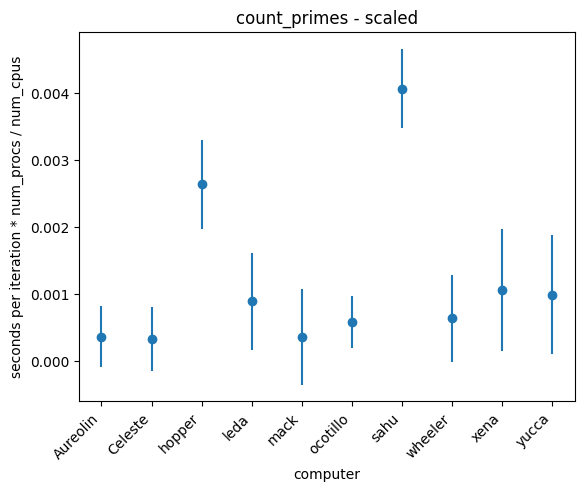

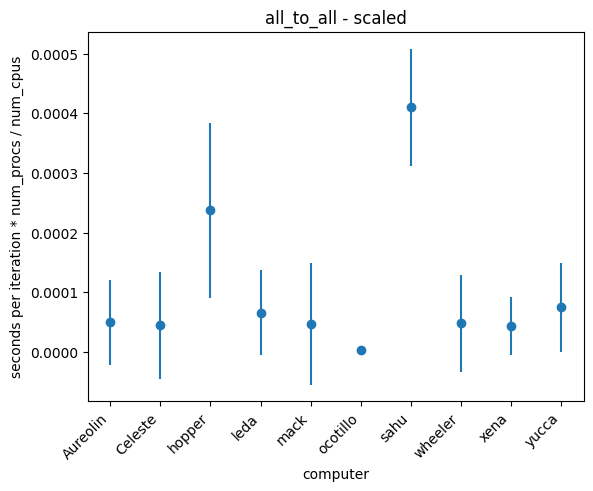

In [45]:
for benchmark in benchmarks:
    fig, ax = plt.subplots()
    ax.set_title(benchmark + " - scaled")
    bench_df = df[df["benchmark"] == benchmark]
    avg = bench_df.groupby("hostname", as_index=False)["scaled"].mean()
    std = bench_df.groupby("hostname", as_index=False)["scaled_std"].mean()
    hostname = avg["hostname"]
    avg = avg["scaled"]
    std = std["scaled_std"]

    ax.errorbar(hostname, avg, yerr=std, marker='o', linestyle='none')
    
    ax.set_xlabel("computer")
    ax.set_ylabel("seconds per iteration * num_procs / num_cpus")
    ax.set_xticks(np.arange(len(hostname)))
    ax.set_xticklabels(hostname, rotation=45, ha="right")
    plt.savefig(benchmark + "_scaled.pdf", bbox_inches="tight")
    plt.show()